In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("/content/Algerian_forest_fires_cleaned_dataset.csv")

In [3]:
df['Classes']=np.where(df['Classes'].str.contains('not fire'),0,1)

In [4]:
df.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0,0
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0,0
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0,0
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0,0
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0,0


In [5]:
remove_cols = ["Classes", "day", "month", "year"]
selected_cols = [x for x in df.columns if x not in remove_cols]
df[selected_cols].head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Region
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0


In [6]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
df[selected_cols] = scalar.fit_transform(df[selected_cols])
df.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,0.35,0.521739,0.521739,0.000000,0.550445,0.041411,0.003279,0.068421,0.034380,0.016077,0,0.0
1,2,6,2012,0.35,0.579710,0.304348,0.077381,0.531157,0.052147,0.003279,0.052632,0.041854,0.012862,0,0.0
2,3,6,2012,0.20,0.884058,0.695652,0.779762,0.274481,0.027607,0.000937,0.015789,0.023916,0.003215,0,0.0
3,4,6,2012,0.15,0.985507,0.304348,0.148810,0.000000,0.009202,0.000000,0.000000,0.008969,0.000000,0,0.0
4,5,6,2012,0.25,0.811594,0.434783,0.000000,0.537092,0.035276,0.034192,0.063158,0.041854,0.016077,0,0.0


In [7]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier

rr = RidgeClassifier(alpha=1.0)

# pick 5 best features
sfs = SequentialFeatureSelector(rr, n_features_to_select=5, direction='backward')

In [8]:
sfs.fit(df[selected_cols], df['Classes'])

SequentialFeatureSelector(direction='backward', estimator=RidgeClassifier(),
                          n_features_to_select=5)

In [9]:
predictors = list(df[selected_cols].columns[sfs.get_support()])
df[predictors].head()

,FFMC,DMC,DC,ISI,FWI
0,0.550445,0.041411,0.003279,0.068421,0.016077
1,0.531157,0.052147,0.003279,0.052632,0.012862
2,0.274481,0.027607,0.000937,0.015789,0.003215
3,0.000000,0.009202,0.000000,0.000000,0.000000
4,0.537092,0.035276,0.034192,0.063158,0.016077


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [11]:
def wedobemodeling(n, model): # we do be modeling though!
    accuracy = []
    for i in range(n):
        # training and test sets
        X_train, X_test, y_train, y_test = train_test_split(df[predictors], df['Classes'], test_size=0.2)

        # fit the model to train
        model.fit(X_train, y_train)

        # predict the fires ;)
        y_pred = model.predict(X_test)

        # accuracy list
        accuracy.append(accuracy_score(y_test, y_pred))

    # actual accuracy
    score = sum(accuracy) / len(accuracy)
    return score

In [12]:
# Use a logistic regression model on the data
model = LogisticRegression()
score = wedobemodeling(1000, model)
print(f"Accuracy: {score}")

# Use a decision tree classifier model on the data
model=DecisionTreeClassifier()
score = wedobemodeling(1000, model)
print(f"Accuracy: {score}")

Accuracy: 0.9417142857142956
Accuracy: 0.9763469387755149


In [13]:
# Use a K-Nearest Neighbors model on the data
k_values = [i for i in range (1,31)]
scores = []
y = df["Classes"]
X=df[predictors]

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(model, X, y, cv=5) # returns accuracy for each fold (5 folds)
    scores.append(np.mean(score)) # taking mean of each fold, to get the average scores for each k

Text(0, 0.5, 'Accuracy Score')

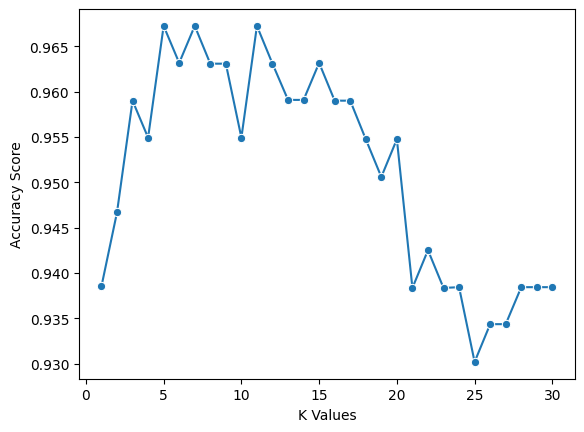

In [14]:
# plot for the accuracy vs. k=# for each model
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [15]:
best_index = np.argmax(scores) # returns index
best_k = k_values[best_index]
best_k

5

In [16]:
model = KNeighborsClassifier(n_neighbors=best_k)
score = wedobemodeling(1000, model)
print(f"Accuracy: {score}")

Accuracy: 0.9558367346938855
